In [21]:
from dotenv import load_dotenv
import pandas as pd
from tqdm.notebook import tqdm
import os

tqdm.pandas()

_ = load_dotenv()

GH_USER = os.environ["GH_USERNAME"]
GH_TOKEN = os.environ["GH_TOKEN"]

In [18]:
sampled_repo_graphics_df = pd.read_csv("sampled_repo_graphics_df.csv")
sampled_repo_graphics_df

,Project,Last_Activity,Contributors,Stargazers,Graphic_Files,Graphic_Files_Length
0,sprossiter/JSIT/,2024-08-26 23:12:56+00:00,1.0,2.0,['src/main/resources/docs/diagrams/alAddDepend...,6
1,baidu/broc/,2024-10-25 16:02:35+00:00,4.0,100.0,"['doc/dependent_relationship.jpg', 'doc/flowch...",3
2,telldus/telldus/,2024-09-09 12:44:16+00:00,10.0,64.0,['telldus-gui/3rdparty/qtsingleapplication/doc...,106
3,Splamy/TS3AudioBot/,2024-11-14 13:01:16+00:00,12.0,698.0,"['TS3AudioBot/Media/SleepingKitty.png', 'TS3Au...",5
4,benmfaul/XRTB/,2024-05-17 07:27:22+00:00,1.0,121.0,"['src/Test.uml', 'src/com/xrtb/bidder/Campaign...",54
...,...,...,...,...,...,...
211,Vdragon/NTOU_CPP_Lab_Opensource_Project/,2024-03-19 13:36:53+00:00,0.0,3.0,"['Lab_6_1/Class_diagram/Lab 6-1.uml', 'Lab_6_2...",2
212,tarbrain/TBStateMachine/,2024-02-13 10:47:56+00:00,1.0,49.0,['Documentation/test_setup.png'],1
213,apache/click/,2024-10-07 04:28:28+00:00,4.0,14.0,['documentation/docs/velocity/images/logo.gif'...,135
214,streambuf/recognition_numbers/,2024-04-16 11:26:55+00:00,1.0,12.0,"['screenshots/1.png', 'screenshots/2.png', 'sc...",4


In [19]:
sampled_repo_graphics_df['Graphic_Files_Length'].sum()

61065

## Check if graphics is UML class diagram

This is a combination of LLM and manual filtering

In [4]:
import torch 
torch.cuda.is_available()

True

In [5]:
from transformers import AutoModel, AutoTokenizer

filepath_model = "C:/Users/biadge/MiniCPM-o-2_6"  # path to the model
model = AutoModel.from_pretrained(filepath_model, 
                                  trust_remote_code=True, 
                                  use_safetensors=True,
                                  attn_implementation='sdpa', 
                                  torch_dtype=torch.bfloat16, 
                                  init_vision=True,
                                  init_audio=True,
                                  init_tts=True)

model = model.eval().cuda()

tokenizer = AutoTokenizer.from_pretrained(filepath_model, trust_remote_code=True)
model.init_tts()

c:\Users\biadge\uml_code_traceability\.venv\Lib\site-packages\transformers\models\auto\image_processing_auto.py:513: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
import requests
import os
from PIL import Image

def run_detect_uml(model, tokenizer, project, file):

    image_url = f"https://raw.githubusercontent.com/{project[:-1]}/master/{file}".format(project=project, file=file)

    # from the image url, download the image to a temporary file which will be deleted later

    os.makedirs(f'images/{project}', exist_ok=True)
    with open(f'images/{project}/{os.path.basename(file)}', 'wb') as f:
        f.write(requests.get(image_url).content)

    try:
        image = Image.open(f'images/{project}/{os.path.basename(file)}').convert('RGB')

        question = "Is this image a UML class diagram? Only answer 'True' if yes or 'False' if no."
        msgs=[{'role': 'user', 
           'content': [image,question]}]
        res = model.chat(
        msgs=msgs,
        tokenizer=tokenizer
    )
    except:
        return "Error"
    finally:
        os.remove(f'images/{project}/{os.path.basename(file)}')

    return res

In [7]:
# uncomment this to run LLM check images for UML class diagram

# from tqdm.notebook import tqdm
# import ast
# tqdm.pandas()

# range_df = range(22)

# for ctr in range_df:
#     print(f"Processing chunk {ctr}")

#     sampled_repo_graphics_df = pd.read_csv(f"sampled_repo_graphics_df_{ctr}.csv")

#     sampled_repo_graphics_df['Graphic_Files'] = sampled_repo_graphics_df['Graphic_Files'].apply(lambda x: ast.literal_eval(x))
#     sampled_repo_graphics_df = sampled_repo_graphics_df.explode('Graphic_Files')
#     sampled_repo_graphics_df = sampled_repo_graphics_df.drop(columns=['Graphic_Files_Length'])
#     sampled_repo_graphics_df = sampled_repo_graphics_df.reset_index(drop=True)

#     print(sampled_repo_graphics_df.shape)

#     sampled_repo_graphics_df['Is_UML'] = sampled_repo_graphics_df.progress_apply(lambda x: run_detect_uml(model, tokenizer, x['Project'], x['Graphic_Files']), axis=1)
#     sampled_repo_graphics_df.to_csv(f"sampled_repo_graphics_uml_df_{ctr}.csv", index=False) 


In [8]:
def run_detect_class_diagram(model, tokenizer, project, file):

    image_url = f"https://raw.githubusercontent.com/{project[:-1]}/master/{file}".format(project=project, file=file)

    # from the image url, download the image to a temporary file which will be deleted later

    os.makedirs(f'llm_check/{project}', exist_ok=True)
    with open(f'llm_check/{project}/{os.path.basename(file)}', 'wb') as f:
        f.write(requests.get(image_url).content)

    try:

        with open(f'llm_check/{project}/{os.path.basename(file)}', 'rb') as file:
            content = file.read()

        question = "Is this image a UML class diagram? Only answer 'True' if yes or 'False' if no."
        msgs=[{'role': 'user', 
           'content': [content,question]}]
        res = model.chat(
        msgs=msgs,
        tokenizer=tokenizer
    )
    except Exception as e:
        print(f"Error with {project} {file}")
        print(e)
        return "Error"

    return res

In [14]:
# get results of LLM and manual filtering

sampled_repo_graphics_uml_df = pd.read_csv("sampled_repo_graphics_uml_df.csv")
sampled_repo_graphics_uml_df = sampled_repo_graphics_uml_df[sampled_repo_graphics_uml_df['Is_UML']]
sampled_repo_graphics_uml_df['File_Type'] = sampled_repo_graphics_uml_df['Graphic_Files'].apply(lambda x: x.rsplit('.', 1)[-1]) 
sampled_repo_graphics_uml_df = sampled_repo_graphics_uml_df[sampled_repo_graphics_uml_df['File_Type'].apply(lambda x: x not in {'uml', 'xmi', 'plantuml', 'puml'})]
sampled_repo_graphics_uml_df = sampled_repo_graphics_uml_df.drop(columns=['Is_UML', 'File_Type']).reset_index(drop=True)
class_diagrams_df = sampled_repo_graphics_uml_df.rename(columns={'Graphic_Files': 'Class_Diagram_File'})
class_diagrams_df = class_diagrams_df.sort_values(by=['Project', 'Class_Diagram_File']).reset_index(drop=True)
class_diagrams_df

,Project,Last_Activity,Contributors,Stargazers,Class_Diagram_File
0,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,AgentClassDiagram.png
1,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,SimulationClassDiagram.png
2,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,doc/AgentClassDiagram.png
3,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,doc/SimulationClassDiagram.png
4,AOKP/frameworks_base_disabled/,2024-07-22 03:39:30+00:00,30,93,docs/html/images/animation/valueanimator.png
...,...,...,...,...,...
929,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_state.png
930,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_strategy.png
931,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_template_method.png
932,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_visitor.png


In [15]:
class_diagrams_df.to_csv("class_diagrams_df.csv", index=False)

In [19]:
from tqdm.notebook import tqdm
import requests
import os

tqdm.pandas()

dup_files = []
ori_files = []

def download_diagram(project, file):

    try:
        image_url = f"https://raw.githubusercontent.com/{project[:-1]}/master/{file}".format(project=project, file=file)

        os.makedirs(f'class_diagrams/{project}', exist_ok=True)

        file_path = f'class_diagrams/{project}/{os.path.basename(file)}'
        if os.path.exists(file_path):
            ori_files.append(file_path)
            file = file.replace('/', '-')
            file_path = f'class_diagrams/{project}/{file}'
            dup_files.append(file_path)
            
        with open(file_path, 'wb') as f:
            f.write(requests.get(image_url).content)

    except Exception as e:
        print(f"Error downloading {file} from {project}: {e}")

In [20]:
class_diagrams_df.progress_apply(lambda x: download_diagram(x['Project'], x['Class_Diagram_File']), axis=1)

  0%|          | 0/934 [00:00<?, ?it/s]

0      None
1      None
2      None
3      None
4      None
       ... 
929    None
930    None
931    None
932    None
933    None
Length: 934, dtype: object

In [21]:
# count number of files in 'class_diagrams' folder and subfolders
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

count_files('class_diagrams')

934

In [85]:
# count number of files in 'class_diagrams' folder and subfolders, AFTER DUPLICATES REMOVED
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

count_files('class_diagrams')

749

In [86]:
934 - 185 # to confirm that 185 duplicate files were removed

749

In [11]:
class_diagrams_df = pd.read_csv("class_diagrams_df.csv")
class_diagrams_df = class_diagrams_df[class_diagrams_df['Duplicate?'] == False].drop(columns=['Duplicate?']).reset_index(drop=True)
class_diagrams_df

,Project,Last_Activity,Contributors,Stargazers,Class_Diagram_File
0,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,AgentClassDiagram.png
1,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,SimulationClassDiagram.png
2,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,doc/AgentClassDiagram.png
3,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,doc/SimulationClassDiagram.png
4,abreitenfeld/QCrystalTile/,2024-03-19 11:37:18+00:00,5,1,doc/architecture/architecture.svg
...,...,...,...,...,...
744,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_state.png
745,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_strategy.png
746,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_template_method.png
747,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_visitor.png


In [13]:
print(f'No. of projects: {class_diagrams_df["Project"].nunique()}')
print(f'No. of class diagrams: {class_diagrams_df.shape[0]}')

No. of projects: 105
No. of class diagrams: 749


In [14]:
projects_df = pd.DataFrame(class_diagrams_df['Project'].unique())
projects_df.columns = ['Project']
projects_df

,Project
0,4dnucleome/cog-abm/
1,abreitenfeld/QCrystalTile/
2,abulka/pynsource/
3,ackepenek/HavayoluSirketSistemi/
4,adityaapte/CERR/
...,...
100,wolandscat/EOMF/
101,WouterJ/wouterj.github.com/
102,wro4j/wro4j-examples/
103,wyon/note/


In [15]:
def get_lines_of_code(repo_name):
    try:
        r = requests.get(f'https://api.github.com/repos/{repo_name}/languages', auth=(GH_USER, GH_TOKEN), timeout=60)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f'Error: {e}')
        return None

    languages = r.json()
    total_lines = sum(languages.values())
    return total_lines

def add_lines_of_code(df):
    tqdm.pandas()
    df['Lines_of_Code'] = df['Project'].progress_apply(lambda repo: get_lines_of_code(repo[:-1]))
    return df

In [26]:
projects_loc_df = add_lines_of_code(projects_df)
projects_loc_df = projects_loc_df[projects_loc_df['Lines_of_Code']>0]

  0%|          | 0/105 [00:00<?, ?it/s]

In [27]:
projects_loc_df.sort_values(by='Lines_of_Code', ascending=False)

,Project,Lines_of_Code
26,blackberry/BB10-WebWorks-Community-Samples/,91721751
86,UnboundID/ldapsdk/,88974637
87,Unidata/awips2/,79543836
10,AOKP/frameworks_base_disabled/,53066690
79,TimLethbridge/umple/,50060767
...,...,...
36,chuxi/chuxi.github.io/,25039
41,sbhatore/SSAD46/,17132
103,wyon/note/,11330
72,symfony/symfony1-docs/,5181


In [30]:
class_diagrams_grouped_df = class_diagrams_df.groupby('Project').size().reset_index(name='No_of_Class_Diagrams')
class_diagrams_grouped_df = class_diagrams_grouped_df.merge(projects_loc_df, on='Project', how='right')
class_diagrams_grouped_df['UML_LOC_ratio'] = class_diagrams_grouped_df['No_of_Class_Diagrams'] / class_diagrams_grouped_df['Lines_of_Code']
class_diagrams_grouped_df

,Project,No_of_Class_Diagrams,Lines_of_Code,UML_LOC_ratio
0,4dnucleome/cog-abm/,4,218076,1.834223e-05
1,abreitenfeld/QCrystalTile/,1,201201,4.970154e-06
2,abulka/pynsource/,15,7428438,2.019267e-06
3,adityaapte/CERR/,3,36085779,8.313524e-08
4,afarber/alexander-farber/,2,1057270,1.891664e-06
...,...,...,...,...
98,wolandscat/EOMF/,2,2938437,6.806340e-07
99,WouterJ/wouterj.github.com/,2,138126,1.447953e-05
100,wro4j/wro4j-examples/,1,11560695,8.649999e-08
101,wyon/note/,21,11330,1.853486e-03


In [35]:
# normalise the UML LOC ratio column
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

class_diagrams_grouped_df['UML_LOC_ratio_scaled'] = scaler.fit_transform(class_diagrams_grouped_df[['UML_LOC_ratio']])
class_diagrams_grouped_df.drop(columns=['UML_LOC_ratio'], inplace=True)
class_diagrams_grouped_df.sort_values(by='UML_LOC_ratio_scaled', ascending=False, inplace=True, ignore_index=True)
class_diagrams_grouped_df

,Project,No_of_Class_Diagrams,Lines_of_Code,UML_LOC_ratio_scaled
0,wyon/note/,21,11330,1.000000e+00
1,wangkuiwu/wangkuiwu.github.io/,44,34570,6.866932e-01
2,xenodium/xenodium.github.io/,1,1705,3.164322e-01
3,symfony/symfony1-docs/,3,5181,3.124012e-01
4,bootchk/pensool/,58,268079,1.167230e-01
...,...,...,...,...
98,Unidata/awips2/,2,79543836,7.683312e-06
99,wakaleo/game-of-life/,1,43114062,6.631730e-06
100,AOKP/frameworks_base_disabled/,1,53066690,4.284747e-06
101,UnboundID/ldapsdk/,1,88974637,1.816148e-07


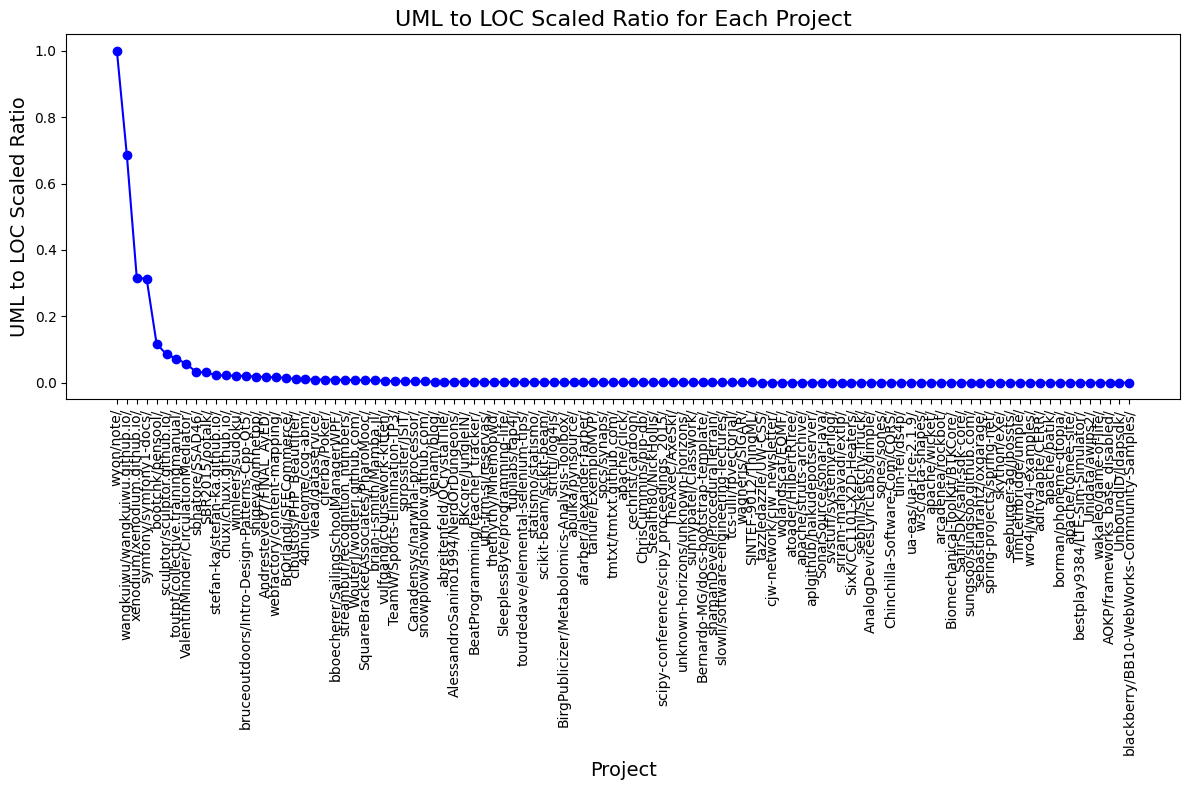

In [39]:
import matplotlib.pyplot as plt

# Plot the UML_LOC_ratio_scaled as a line diagram
plt.figure(figsize=(12, 8))
plt.plot(class_diagrams_grouped_df['Project'], class_diagrams_grouped_df['UML_LOC_ratio_scaled'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Project', fontsize=14)
plt.ylabel('UML to LOC Scaled Ratio', fontsize=14)
plt.title('UML to LOC Scaled Ratio for Each Project', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

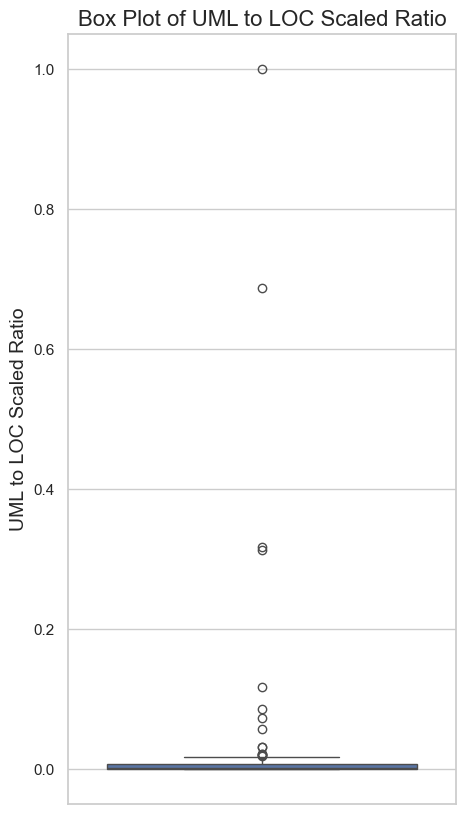

In [44]:
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(5, 10))
sns.boxplot(data=class_diagrams_grouped_df, y='UML_LOC_ratio_scaled')

# Add labels and title
plt.ylabel('UML to LOC Scaled Ratio', fontsize=14)
plt.title('Box Plot of UML to LOC Scaled Ratio', fontsize=16)

# Show the plot
plt.show()

### Get old UML models

In [ ]:
full_repo_model_df = pd.read_csv('UMLFiles_List_V2.0.csv')

# clean the string in model link to just reflect file name similar to UML files in uml_loc_df, include the directory from root
full_repo_model_df['Model Link - Github'] = full_repo_model_df['Model Link - Github'].apply(lambda x: x.split('master/')[-1])
# groupby the Projects
grouped_models_df = full_repo_model_df.groupby('Project')['Model Link - Github'].apply(list).reset_index()
# every element in the model link list to be encaved in ' ' since they are strings
grouped_models_df['Model Link - Github'] = grouped_models_df['Model Link - Github'].apply(lambda x: [f"'{y}'" for y in x])
# add length of model link list
grouped_models_df['Model Link Length'] = grouped_models_df['Model Link - Github'].apply(len)

# rename the columns
grouped_models_df.rename(columns={'Model Link - Github': 'Old_UML_Files', 'Model Link Length': 'Old_UML_Files_Length'}, inplace=True)
grouped_models_df

,Project,Old_UML_Files,Old_UML_Files_Length
0,0-complexity/ovcdoc_public/,['Sysadmin/AdminArchitecture.png'],1
1,0003088/libelektra-qt-gui-test/,['doc/images/overview_plugins.xmi'],1
2,00s/deadman/,['diagram/zombie-game Activity Diagram.png'],1
3,01db0y/ImageUploader/,['Content/img/Class Diagram1.png'],1
4,01db0y/ShareIt/,['FancyImageUploader/Content/img/Class Diagram...,1
...,...,...,...
24725,zyq001/SDN-based-PubSub-System/,['wsn-sdn/logs/umltest.uml'],1
24726,zyxstar/md_note/,"['imgs/effective_uml_01.png', 'imgs/effective_...",37
24727,zz2/zft/,['dashboard/doc/rackspace-python-cloudfiles-e8...,42
24728,zztimy/as1_Counter/,['doc/timoteiUML.jpeg'],1


In [ ]:
# Ensure 'Project' column is of type string in both dataframes
grouped_uml_files_df['Project'] = grouped_uml_files_df['Project'].astype(str)
grouped_models_df['Project'] = grouped_models_df['Project'].astype(str)

# Get the previous UML files for each project
merged_uml_df = grouped_uml_files_df.join(grouped_models_df.set_index('Project'), on='Project', how='left')
merged_uml_df.reset_index(drop=True, inplace=True)
merged_uml_df = merged_uml_df[['Project', 'Last_Activity', 'Contributors', 'Stargazers', 'Lines_of_Code', 'UML_LOC_ratio_scaled', 'UML_Files',  'Old_UML_Files', 'UML_Files_Length', 'Old_UML_Files_Length']]
merged_uml_df.to_csv('merged_uml_df.csv', index=False)

In [ ]:
merged_uml_df.head()

,Project,Last_Activity,Contributors,Stargazers,Lines_of_Code,UML_LOC_ratio_scaled,UML_Files,Old_UML_Files,UML_Files_Length,Old_UML_Files_Length
0,AnalogDevicesLyricLabs/dimple/,2024-04-02 07:25:15+00:00,4,80,7224951,0.000173,['modelers/matlab/lib/xunit_dist/matlab_xunit/...,['modelers/matlab/lib/xunit_dist/matlab_xunit/...,3,3
1,AnimalPlanet/pdf-to-mindmap-and-ppt-with-textr...,2024-10-16 15:35:57+00:00,2,3,14224669,0.000036,"['class-diagram.gif', 'final_class_diagram.gif']","['class-diagram.gif', 'final_class_diagram.gif']",2,2
2,Stealth80/NickHollis/,2023-12-07 01:55:40+00:00,1,0,624377,0.030489,['MobileFriendlyWebApp/public/img/class-diagra...,['MobileFriendlyWebApp/public/img/class-diagra...,1,1
3,ValentinMinder/CirculationMediator/,2024-05-02 14:47:54+00:00,3,1,47692,0.014892,['TheoreticalMediator/presentation/graphics/UM...,['TheoreticalMediator/presentation/graphics/UM...,5,5
4,abulka/pynsource/,2024-11-09 15:06:43+00:00,4,287,7428438,0.000608,"['Admin/doco-uml/OGL-like UML 2015.png', 'Admi...","['Admin/doco-uml/OGL-like UML.png', 'Research/...",14,8


In [ ]:
merged_uml_df.tail()

,Project,Last_Activity,Contributors,Stargazers,Lines_of_Code,UML_LOC_ratio_scaled,UML_Files,Old_UML_Files,UML_Files_Length,Old_UML_Files_Length
15,sones/sones/,2024-11-12 20:04:40+00:00,5,213,8246454,0.000375,['Documentation/media/documentation/database/e...,['Documentation/media/documentation/database/e...,1,3
16,tlin-fei/ds4p/,2024-01-13 23:52:04+00:00,0,1,6462777,0.000370,['DS4P/acs-showcase/ACS Showcase Class Diagram...,['DS4P/acs-showcase/ACS Showcase Class Diagram...,2,4
17,universAAL/ontology/,2024-09-06 05:54:56+00:00,9,13,3349200,0.001057,['ont.cryptographic/src/main/javadoc/Cryptogra...,['ont.lighting/documentation/ont.lighting clas...,9,18
18,urielbautista/dev/,2024-04-14 01:03:38+00:00,0,0,302563,0.035686,['pattern/src/main/java/mx/umb/pattern/concurr...,['pattern/src/main/java/mx/umb/pattern/concurr...,49,1
19,xenodium/xenodium.github.io/,2024-11-13 13:22:10+00:00,3,9,1705,1.000000,['images/plantuml-example/plantuml-singer.png'],['images/plantuml-example/plantuml-singer.png'],1,1


In [ ]:
merged_uml_df

,Project,Last_Activity,Contributors,Stargazers,Lines_of_Code,UML_LOC_ratio_scaled,UML_Files,Old_UML_Files,UML_Files_Length,Old_UML_Files_Length
0,AnalogDevicesLyricLabs/dimple/,2024-04-02 07:25:15+00:00,4,80,7224951,0.000173,['modelers/matlab/lib/xunit_dist/matlab_xunit/...,['modelers/matlab/lib/xunit_dist/matlab_xunit/...,3,3
1,AnimalPlanet/pdf-to-mindmap-and-ppt-with-textr...,2024-10-16 15:35:57+00:00,2,3,14224669,0.000036,"['class-diagram.gif', 'final_class_diagram.gif']","['class-diagram.gif', 'final_class_diagram.gif']",2,2
2,Stealth80/NickHollis/,2023-12-07 01:55:40+00:00,1,0,624377,0.030489,['MobileFriendlyWebApp/public/img/class-diagra...,['MobileFriendlyWebApp/public/img/class-diagra...,1,1
3,ValentinMinder/CirculationMediator/,2024-05-02 14:47:54+00:00,3,1,47692,0.014892,['TheoreticalMediator/presentation/graphics/UM...,['TheoreticalMediator/presentation/graphics/UM...,5,5
4,abulka/pynsource/,2024-11-09 15:06:43+00:00,4,287,7428438,0.000608,"['Admin/doco-uml/OGL-like UML 2015.png', 'Admi...","['Admin/doco-uml/OGL-like UML.png', 'Research/...",14,8
5,adityaapte/CERR/,2024-11-06 14:09:43+00:00,7,192,36085779,0.000024,['Unit_Testing/matlab_xunit_3/matlab_xunit/arc...,['Unit_Testing/matlab_xunit_3/matlab_xunit/arc...,3,3
6,arcadenea/rockbot/,2024-08-11 21:17:27+00:00,2,5,3733067,0.000110,['docs/diagram.png'],"['docs/diagram.png', 'docs/diagram.xmi']",1,2
7,asterisk/pjproject/,2024-10-29 14:10:51+00:00,30,6,18691283,0.000027,['pjnath/docs/UML-class-diagram.png'],['pjnath/docs/UML-class-diagram.png'],1,1
8,atoader/HilbertRTree/,2024-08-27 02:06:41+00:00,1,31,1524148,0.000183,['doc/Report/img/ClassDiagram.png'],['doc/Report/img/ClassDiagram.png'],1,1
9,berlinbrown/openbotlist/,2024-08-17 22:11:57+00:00,1,2,2668939,0.000209,"['botlist/docs/enterprise/UserLinks.png', 'bot...",['botlist/docs/enterprise/system_feeds/SystemF...,2,2


In [ ]:
def download_old_uml_files(df):
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        repo_name = row['Project'][:-1]
        uml_file = row['Old_UML_File']
        sanitized_repo_name = sanitize_folder_name(repo_name)
        dest_folder = os.path.join('old_images', sanitized_repo_name)
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder, exist_ok=True)
        file_url = f'https://raw.githubusercontent.com/{repo_name}/master/{uml_file}'
        download_file(file_url, dest_folder)

download_old_uml_files(dl_old_uml_df_split)

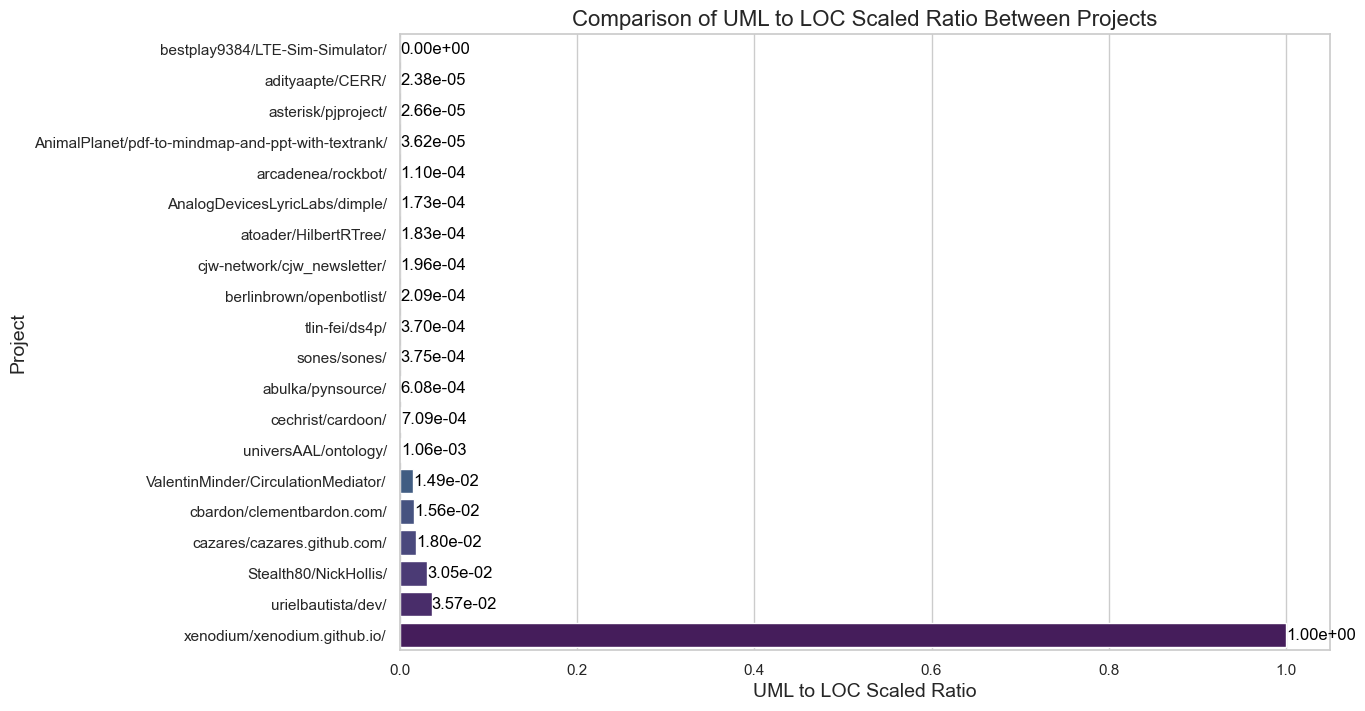

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Sort the dataframe by UML_LOC_Ratio
merged_df_sorted = merged_uml_df.sort_values(by='UML_LOC_ratio_scaled', ascending=False)

# Plot the UML_LOC_Ratio
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x='UML_LOC_ratio_scaled', 
    y='Project', 
    data=merged_df_sorted, 
    palette='viridis'
)

# Add labels and title
plt.xlabel('UML to LOC Scaled Ratio', fontsize=14)
plt.ylabel('Project', fontsize=14)
plt.title('Comparison of UML to LOC Scaled Ratio Between Projects', fontsize=16)

# Add value annotations
for index, value in enumerate(merged_df_sorted['UML_LOC_ratio_scaled']):
    barplot.text(value, index, f'{value:.2e}', color='black', ha="left", va="center")

# Invert y-axis to have the highest ratio at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()